<a href="https://colab.research.google.com/github/spadrejuan/ml-final-project/blob/Nat-Branch/Nat-ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### For Google Colab to import Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# %pip install opencv-python

## Convert JPG to JPEG

In [50]:
import cv2
import os
from pathlib import Path
# DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

# For Google Colab
DATA_DIR = "drive/MyDrive/dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        files = os.path.join(data_dir,dir_name)
        for filepaths in os.listdir(files):
            file_names = os.path.join(files,filepaths)
            if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                img = cv2.imread(str(file_names))
                cv2.imwrite(file_names[0:-4]+".jpeg", img)
                os.remove(file_names)

In [51]:
import imghdr

IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Import Tensorflow and Keras

In [42]:
import tensorflow as tf
import keras

BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

## StableDiffusion Dataset

In [62]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,
    subset="training",
)

val_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2, # use 20% as validation
    subset="validation",
)
# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 913 files belonging to 2 classes.
Using 731 files for training.
Found 913 files belonging to 2 classes.
Using 182 files for validation.
['AI Art', 'Real']


In [63]:
import numpy as np
from sklearn.utils import shuffle

# Shuffle the training dataset
train_dataset = train_dataset.shuffle(len(train_dataset), seed=1337)

# Separate images and labels
images = []
labels = []
for image_batch, label_batch in train_dataset:
    images.extend(image_batch)
    labels.extend(label_batch)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Find the class with fewer samples
unique_labels, class_counts = np.unique(labels, return_counts=True)
minority_class = unique_labels[np.argmin(class_counts)]

# Find the indices of the minority class
minority_indices = np.where(labels == minority_class)[0]

# Randomly sample from the majority class
majority_indices = np.where(labels != minority_class)[0]
num_samples_to_keep = len(minority_indices)
majority_indices_sampled = np.random.choice(majority_indices, size=num_samples_to_keep, replace=False)

# Combine indices of both classes
balanced_indices = np.concatenate([minority_indices, majority_indices_sampled])

# Shuffle the combined indices
balanced_indices = shuffle(balanced_indices, random_state=1337)

# Use the balanced indices to create the balanced dataset
balanced_images = images[balanced_indices]
balanced_labels = labels[balanced_indices]

# Create TensorFlow Dataset from balanced data
balanced_train_dataset = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))
balanced_train_dataset = balanced_train_dataset.shuffle(len(balanced_images)).batch(BATCH_SIZE)

# Print class distribution in the balanced dataset
unique_labels, class_counts = np.unique(balanced_labels, return_counts=True)
print("Class distribution in the balanced dataset:")
for label, count in zip(unique_labels, class_counts):
    print(f"Class {label}: {count} samples")

Class distribution in the balanced dataset:
Class 0.0: 320 samples
Class 1.0: 320 samples


# Display sample images

<ipython-input-45-d99948db8ca7>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])


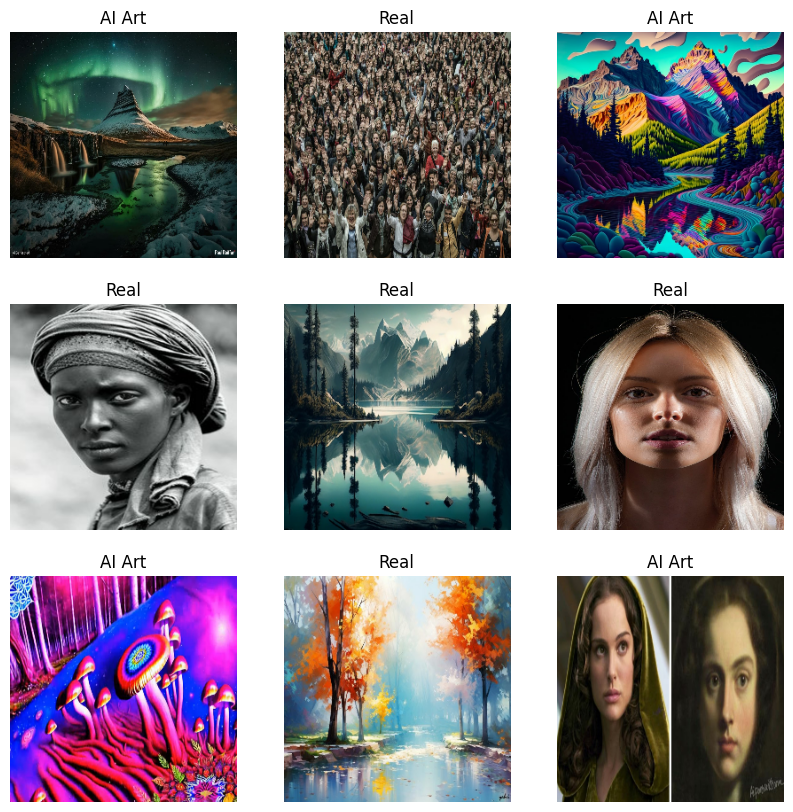

In [45]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")

display_binary_images(train_dataset, class_names)

## Model

In [64]:
import tensorflow as tf

# Load the ResNet50 model pre-trained on ImageNet data
base_model = tf.keras.applications.ResNet50(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')

# Freeze the layers in the base model
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Combine the base model with the custom classification head
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])


In [65]:
NUM_EPOCHS = 10  # Number of epochs for training

In [66]:
# Define Learning Rate Scheduling callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1             # Print message when learning rate is reduced
)

# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print message when training is stopped
    restore_best_weights=True  # Restore model weights to the point of best validation loss
)

In [67]:
# Train the model
history = model.fit(balanced_train_dataset,
                    epochs=NUM_EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[lr_scheduler, early_stopping]
                    )


Epoch 1/10
10/10 [==============================] - 17s 2s/step - loss: 0.6898 - binary_accuracy: 0.5656 - val_loss: 0.6663 - val_binary_accuracy: 0.5769 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 7s 758ms/step - loss: 0.5396 - binary_accuracy: 0.7250 - val_loss: 0.5692 - val_binary_accuracy: 0.7253 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 7s 734ms/step - loss: 0.4593 - binary_accuracy: 0.7875 - val_loss: 0.5254 - val_binary_accuracy: 0.7747 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 7s 762ms/step - loss: 0.4121 - binary_accuracy: 0.8313 - val_loss: 0.4972 - val_binary_accuracy: 0.7912 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 8s 874ms/step - loss: 0.3729 - binary_accuracy: 0.8562 - val_loss: 0.4782 - val_binary_accuracy: 0.8022 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - 7s 754ms/step - loss: 0.3447 - binary_accuracy: 0.8609 - val_loss: 0.4664 - val_binar

In [68]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [69]:
# Train the model
history = model.fit(balanced_train_dataset,
                    epochs=NUM_EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[lr_scheduler, early_stopping]
                    )

Epoch 1/10
10/10 [==============================] - 49s 2s/step - loss: 0.3829 - binary_accuracy: 0.8469 - val_loss: 0.4856 - val_binary_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 0.2493 - binary_accuracy: 0.9484 - val_loss: 0.4901 - val_binary_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - 18s 2s/step - loss: 0.1845 - binary_accuracy: 0.9812 - val_loss: 0.4442 - val_binary_accuracy: 0.8022 - lr: 1.0000e-05
Epoch 4/10
10/10 [==============================] - 13s 1s/step - loss: 0.1361 - binary_accuracy: 0.9953 - val_loss: 0.4206 - val_binary_accuracy: 0.8242 - lr: 1.0000e-05
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 0.0994 - binary_accuracy: 1.0000 - val_loss: 0.4062 - val_binary_accuracy: 0.8352 - lr: 1.0000e-05
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.0774 - binary_accuracy: 1.0000 - val_loss: 0.3968 - val_binary_accuracy